In [1]:
import json
import mysql.connector
import getpass
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

with open('config.json') as f:
    config = json.load(f)

host_name = config['host']
user_name = config['user']
passwd = getpass.getpass(prompt='Enter your password: ')
csv_path = config['csv_path']

In [13]:
cnx = mysql.connector.connect(user=user_name, password=passwd, host=host_name)

cursor = cnx.cursor()
cursor.execute("DROP DATABASE IF EXISTS DB_wine")
cursor.execute("CREATE DATABASE IF NOT EXISTS DB_wine")
cursor.execute("USE DB_wine")

# Define the table name and columns
table_name = 'wine'
header = ['Class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']
columns = ', '.join([f"`{column}` VARCHAR(255)" for column in header])

# Create the table
create_table_query = f"CREATE TABLE `{table_name}` ({columns}) ENGINE=InnoDB"
cursor.execute(create_table_query)

df = pd.read_csv(csv_path)

# Insert the data into the table
for _, row in df.iterrows():
    values = ", ".join([f"'{str(value)}'" for value in row])
    insert_query = f"INSERT INTO `{table_name}` VALUES ({values})"
    cursor.execute(insert_query)

# Commit the changes and close the connection
cnx.commit()


In [14]:
# Execute a SELECT query to fetch data from the table
select_query = f"SELECT * FROM wine"
cursor.execute(select_query)

# Fetch all the rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [column[0] for column in cursor.description]

# Convert the fetched data into a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
cnx.close()

# Print the DataFrame
print(df)

    Class Alcohol Malicacid   Ash Alcalinity_of_ash Magnesium Total_phenols   
0     1.0    13.2      1.78  2.14              11.2     100.0          2.65  \
1     1.0   13.16      2.36  2.67              18.6     101.0           2.8   
2     1.0   14.37      1.95   2.5              16.8     113.0          3.85   
3     1.0   13.24      2.59  2.87              21.0     118.0           2.8   
4     1.0    14.2      1.76  2.45              15.2     112.0          3.27   
..    ...     ...       ...   ...               ...       ...           ...   
172   3.0   13.71      5.65  2.45              20.5      95.0          1.68   
173   3.0    13.4      3.91  2.48              23.0     102.0           1.8   
174   3.0   13.27      4.28  2.26              20.0     120.0          1.59   
175   3.0   13.17      2.59  2.37              20.0     120.0          1.65   
176   3.0   14.13       4.1  2.74              24.5      96.0          2.05   

    Flavanoids Nonflavanoid_phenols Proanthocyanins

In [15]:
# 執行 PCA 分析
pca = PCA(n_components=3)  # 指定 PCA 的維度
class_var = df['Class']
features = df.drop('Class', axis=1)  #  從特徵中排除目標變數 Class
pca_result = pca.fit_transform(features)

# 將類別變數轉換為數值表示
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(class_var)

# 解釋變異性比例
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio:', explained_variance_ratio)

# 累積解釋變異性比例
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print('Cumulative Explained Variance Ratio:', cumulative_explained_variance_ratio)

Explained Variance Ratio: [9.98107426e-01 1.71938802e-03 9.49401506e-05]
Cumulative Explained Variance Ratio: [0.99810743 0.99982681 0.99992175]


          PC1        PC2       PC3  Target
0  304.898866  -5.139198  6.845472       0
1  439.863485  -6.239584 -1.085021       0
2  735.039781   0.605870 -0.858411       0
3   -9.778966  18.608535 -0.492842       0
4  705.030955   0.065444  1.007589       0


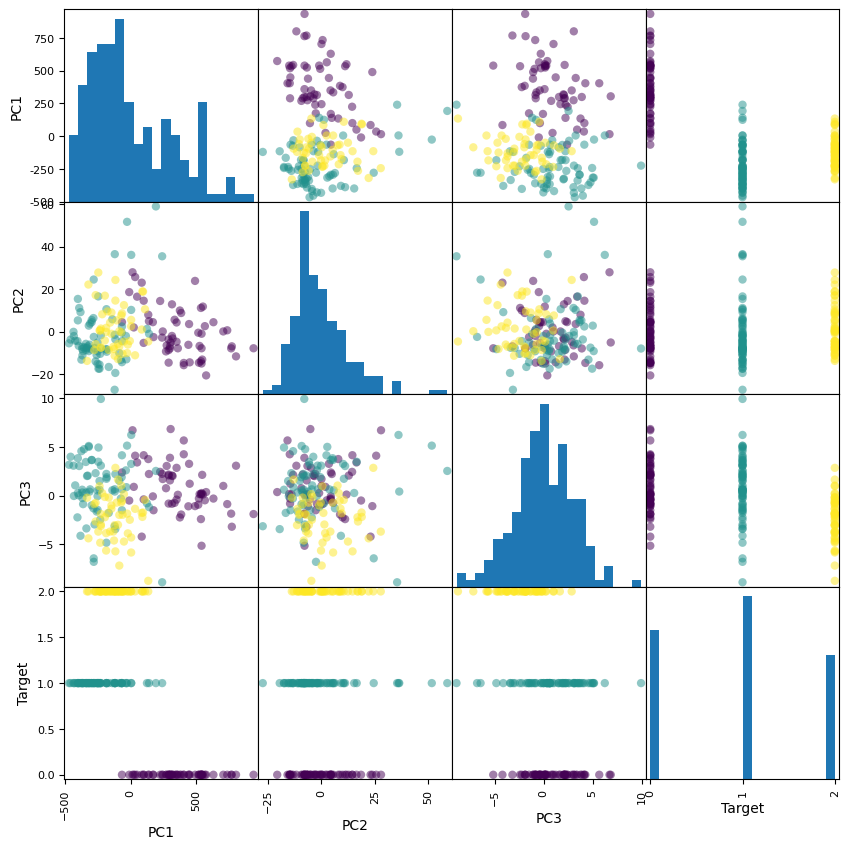

In [16]:
# 創建包含主成分的 DataFrame
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['Target'] = class_encoded
print(df_pca.head())

# 使用散點矩陣繪製可視化圖表
pd.plotting.scatter_matrix(df_pca, c=df_pca['Target'], figsize=(10, 10), marker='o', hist_kwds={'bins': 20})
plt.show()